In [2]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-902v_x_7
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-902v_x_7
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.4 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=c40385914f0a511d9fa870673abe6be1d91e65702ec3e2d6ce038ef81a033119
  Stored in directory: /tmp/pip-ephem-wheel-cache-tbrx2hre/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [3]:
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the MNIST dataset
mnist_data = MNIST('.', download=True, transform=ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size=60000)
x, y = next(iter(dataloader))

100%|██████████| 9912422/9912422 [00:00<00:00, 102945850.65it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9527740.59it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29704374.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14744991.31it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# Reshape and prepare data
x = x.detach().cpu().numpy().reshape(len(x), -1)  # Flatten the images
y = y.detach().cpu().numpy()

In [6]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=0, stratify=y)


In [7]:
# Initialize the Active Learner with Decision Tree
learner = ActiveLearner(
    estimator=DecisionTreeClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

In [8]:
# Function to print and plot metrics
def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    conf_mat = confusion_matrix(y_true, y_pred)

    print('Accuracy:', acc)
    print('Macro F1-score:', macro_f1)
    print('Micro F1-score:', micro_f1)
    print('Weighted F1-score:', weighted_f1)
    print('Confusion Matrix:\n', conf_mat)

    # Plotting confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Performance after query 1:
Accuracy: 0.8659
Macro F1-score: 0.864522048930449
Micro F1-score: 0.8659
Weighted F1-score: 0.865947468799671
Confusion Matrix:
 [[ 905    2   11    6    4   14   12    4   17   12]
 [   1 1069    9   12    2    6    4    7    8    6]
 [  10   14  836   34    6   10   23   16   38    6]
 [  11    9   32  841    8   50    4   12   35   20]
 [   6    9   14    5  835    7   13   14   19   52]
 [   9    7   10   41   13  752   17    9   27   18]
 [  16    9   14    5    8   22  886    5   14    7]
 [   6    7   20   16    9    8    0  931   14   33]
 [   9   14   24   48   20   20   20   12  790   18]
 [   4    7    6   29   50   29    1   25   27  814]]


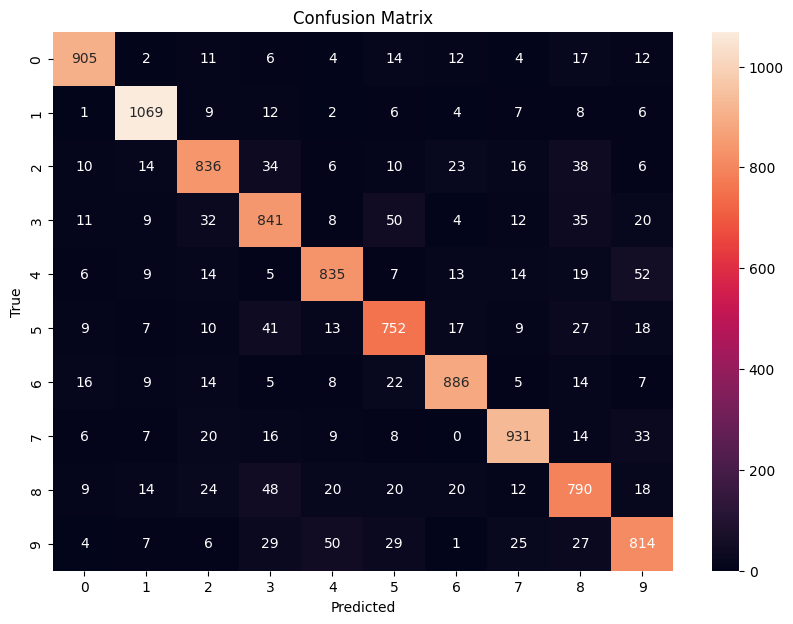

Performance after query 2:
Accuracy: 0.868
Macro F1-score: 0.8666522271281846
Micro F1-score: 0.868
Weighted F1-score: 0.8679965603163224
Confusion Matrix:
 [[ 902    2   14    8    9   13   15    6   10    8]
 [   1 1072   11   12    3    5    3    7    6    4]
 [  12   17  835   30    5   10   19   16   39   10]
 [  14    8   23  840    8   55    3   14   38   19]
 [   4   13   19    6  842    3    9   18   17   43]
 [  10    7   10   42    9  758   13    6   26   22]
 [  14    7   14    4   12   25  881    5   16    8]
 [   1    5   18    9    9   12    1  937   17   35]
 [   8   17   26   37   17   19   21   13  793   24]
 [   5   11   11   28   49   19    2   21   26  820]]


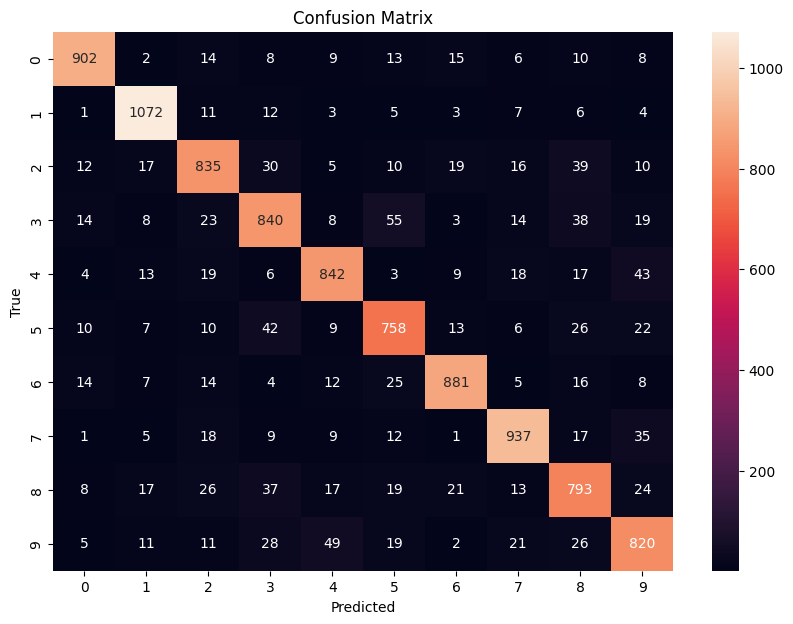

Performance after query 3:
Accuracy: 0.8646
Macro F1-score: 0.8631770734978277
Micro F1-score: 0.8646
Weighted F1-score: 0.8646307165235838
Confusion Matrix:
 [[ 896    2   12    8    5   22   13    8   14    7]
 [   2 1064   10   14    2    6    2    9    9    6]
 [  11   18  831   33    9   11   16   15   36   13]
 [  13    9   35  833    8   59    7   13   33   12]
 [   6    7    9    3  847   10   11   15   21   45]
 [   8    8   10   37    8  751   19    7   29   26]
 [  16    9   15    5   10   25  883    5   11    7]
 [   3   10   17   13    8    6    4  940   11   32]
 [   5   18   20   42   18   25   22    8  796   21]
 [   4    8   14   23   49   27    2   28   32  805]]


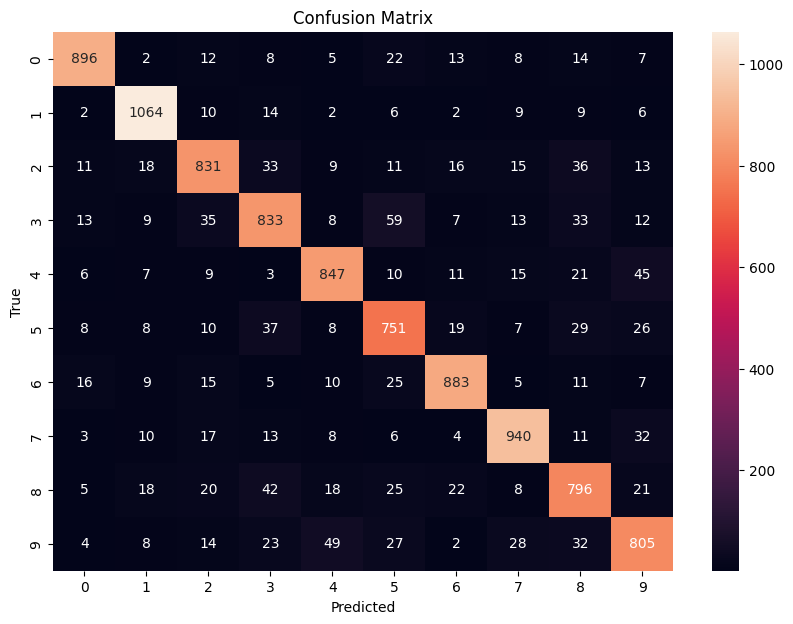

Performance after query 4:
Accuracy: 0.8677
Macro F1-score: 0.8661842934260126
Micro F1-score: 0.8677
Weighted F1-score: 0.8676095744936261
Confusion Matrix:
 [[ 900    2   12    9    7   16   11    6   14   10]
 [   1 1068   11   12    4    4    4   11    5    4]
 [  14   15  837   29    7    9   18   14   36   14]
 [  14    8   26  848    7   52    2   15   33   17]
 [  12   11   13    4  837    5   13   14   17   48]
 [  12    5   11   33    6  755   19    7   31   24]
 [  15   10   15    1    8   24  886    5   14    8]
 [   5    6   19    9    6    3    2  947   17   30]
 [   7   18   21   43   18   24   21   10  787   26]
 [   4    6   10   23   51   25    4   32   25  812]]


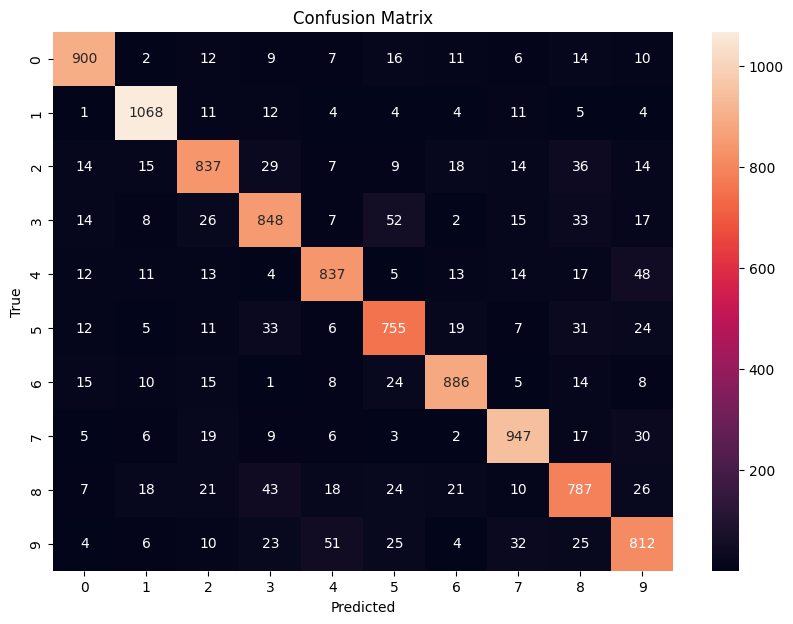

Performance after query 5:
Accuracy: 0.8681
Macro F1-score: 0.8666934546312536
Micro F1-score: 0.8680999999999999
Weighted F1-score: 0.8681695354783331
Confusion Matrix:
 [[ 893    1   13   12    5   19   15    8   13    8]
 [   2 1070    9   11    5    6    4    6    7    4]
 [  11   21  830   30   11   12   20   13   33   12]
 [  12   11   18  854    7   48    7   11   34   20]
 [   1   12   17    5  845    3   14   12   18   47]
 [  12    7   10   37    9  754   17    7   25   25]
 [  14    5   14    5   13   30  884    5   11    5]
 [   1    4   17   15   10    9    5  935   18   30]
 [   8   14   27   47   20   21   21   10  791   16]
 [   3    7    9   24   51   24    3   18   28  825]]


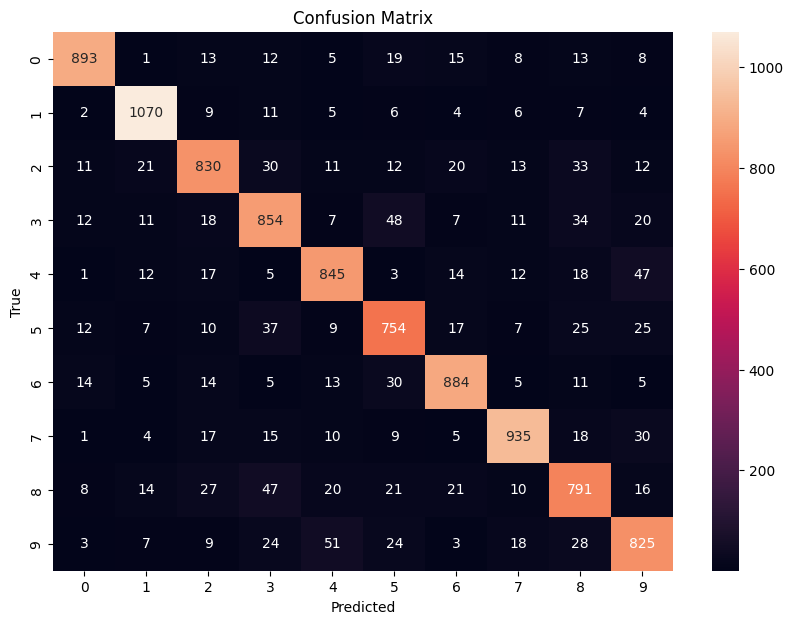

Performance after query 6:
Accuracy: 0.864
Macro F1-score: 0.8624852984047425
Micro F1-score: 0.864
Weighted F1-score: 0.8639947154577562
Confusion Matrix:
 [[ 898    3   16    7    3   15   14    9   16    6]
 [   4 1064   12   13    3    6    4    7    8    3]
 [  11   21  826   26    8   13   23   13   40   12]
 [  16    7   26  848    7   52    9   12   31   14]
 [   4   10   18    3  834    9   12   12   19   53]
 [   9    4    9   42    6  744   22    7   32   28]
 [  17   10   19    4   11   22  878    4   12    9]
 [   2    4   19   12    7   11    2  944   15   28]
 [   7   16   27   42   23   22   17   11  790   20]
 [   4    8    5   26   46   20    3   36   30  814]]


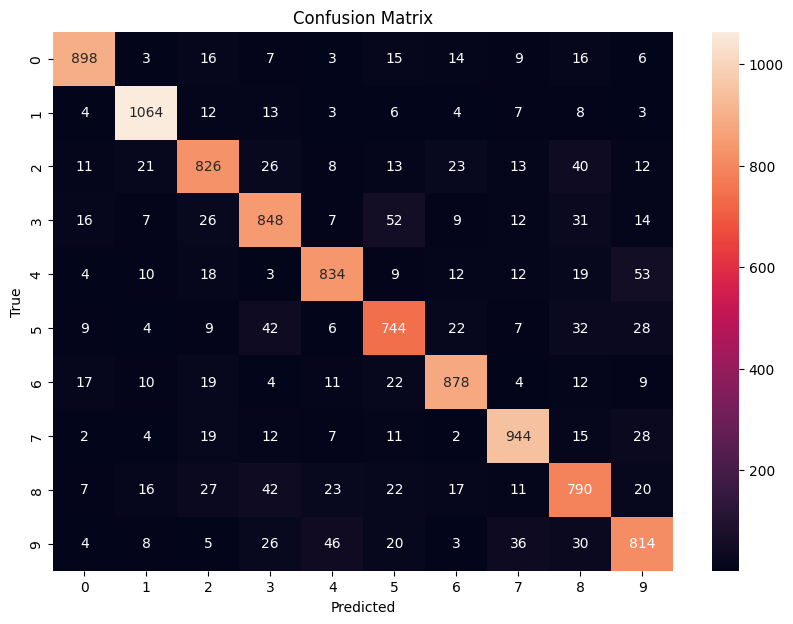

Performance after query 7:
Accuracy: 0.8663
Macro F1-score: 0.8647970569645788
Micro F1-score: 0.8663
Weighted F1-score: 0.8663242004412844
Confusion Matrix:
 [[ 901    3   12    7    8   12   15    6   13   10]
 [   1 1069   10   12    3    6    1   11    7    4]
 [  13   17  830   31   11   10   22   13   38    8]
 [  10   10   25  847   10   55    5    8   35   17]
 [   8   10   12    3  841    5   13   12   19   51]
 [   8    7    7   45   10  746   18    4   32   26]
 [  16    7   19    4    7   30  877    5   13    8]
 [   2    8   21   11    7    4    0  944   19   28]
 [   6   16   32   43   21   25   18   10  785   19]
 [   2   10    8   20   47   28    2   29   23  823]]


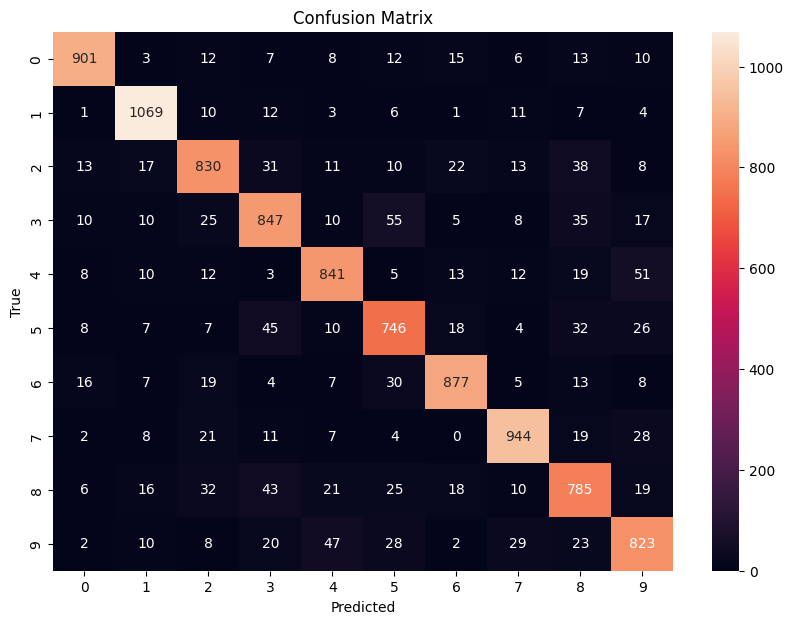

Performance after query 8:
Accuracy: 0.8693
Macro F1-score: 0.8678056273183724
Micro F1-score: 0.8693000000000001
Weighted F1-score: 0.8691703767152817
Confusion Matrix:
 [[ 903    2   17    8    6   14   13    6   12    6]
 [   1 1074    6   12    3    6    4    8    8    2]
 [  12   17  840   30    9   11   15   14   36    9]
 [  14   12   31  846   10   46    3   12   32   16]
 [   5   12   16    5  840    6   11   13   18   48]
 [  15   10   10   42    8  746   20    7   23   22]
 [  16    6   12    6    9   26  890    5   11    5]
 [   3    8   22   12    7    9    3  939   13   28]
 [   7   18   34   37   19   18   17   13  795   17]
 [   3   10    6   29   47   20    5   22   30  820]]


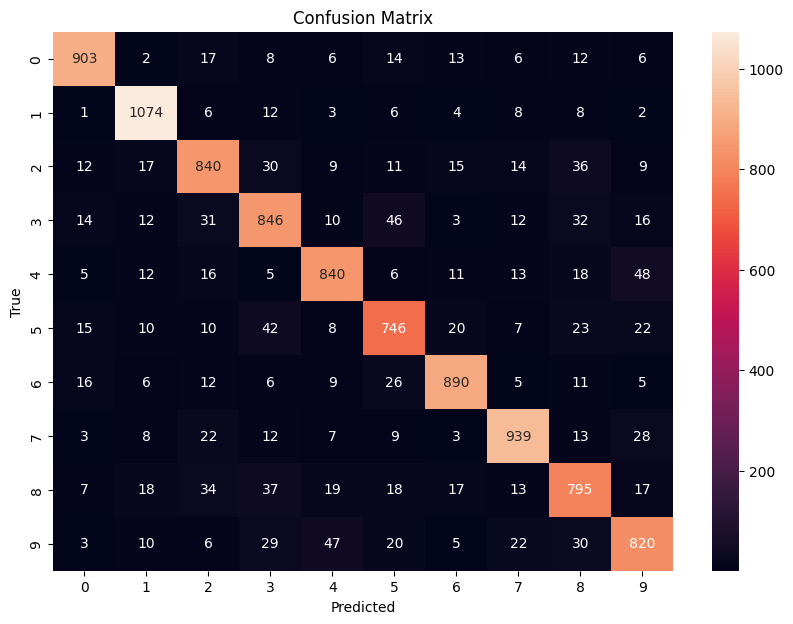

Performance after query 9:
Accuracy: 0.8674
Macro F1-score: 0.8660170249682348
Micro F1-score: 0.8674
Weighted F1-score: 0.8674166217665875
Confusion Matrix:
 [[ 904    2   16    6    4   15   12    7   13    8]
 [   3 1061   14   11    4    4    4   11    6    6]
 [  13   15  838   32   12   11   21    9   29   13]
 [   9   13   24  847   11   54    3   13   32   16]
 [   4    9   16    1  841    7   14   15   19   48]
 [  11    5    7   36    6  759   15    7   30   27]
 [  17    6   15    4   14   30  876    6   12    6]
 [   3    9   19   13    9    9    6  940   10   26]
 [   7   17   27   36   16   25   20   11  794   22]
 [   5    7    9   25   44   24    3   28   33  814]]


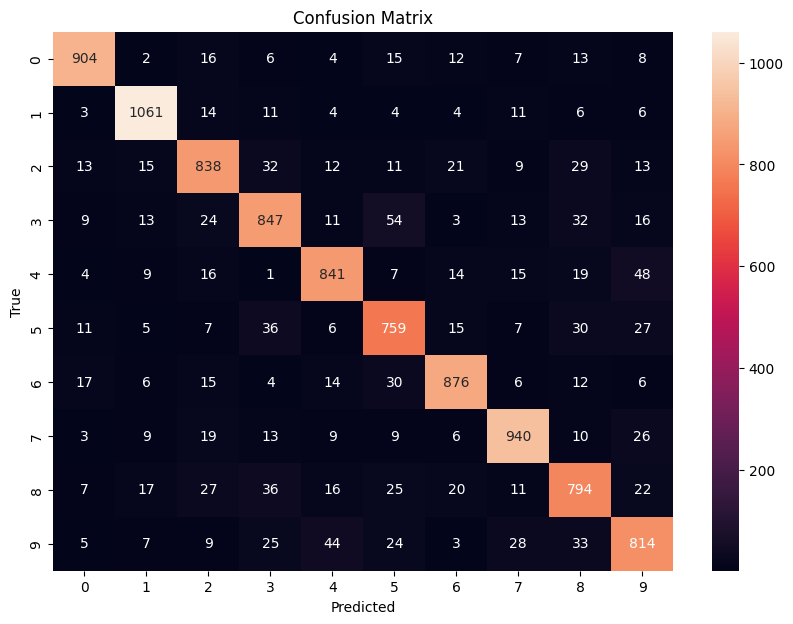

Performance after query 10:
Accuracy: 0.8682
Macro F1-score: 0.866721609049349
Micro F1-score: 0.8682
Weighted F1-score: 0.8682043878871873
Confusion Matrix:
 [[ 904    1   16    8    4   15   11    6   14    8]
 [   1 1072    8   14    1    7    3    7    7    4]
 [  13   18  842   29    9    9   20    9   33   11]
 [  18    7   31  843    8   51    4   12   31   17]
 [   5   10   16    5  841    6   13   12   18   48]
 [   8   10   10   43    9  744   17    7   30   25]
 [  13   10   18    6    8   23  881    5   14    8]
 [   4    4   17   12    7   12    2  943   10   33]
 [   6   17   27   44   19   24   20   12  788   18]
 [   3    9    7   29   41   24    1   27   27  824]]


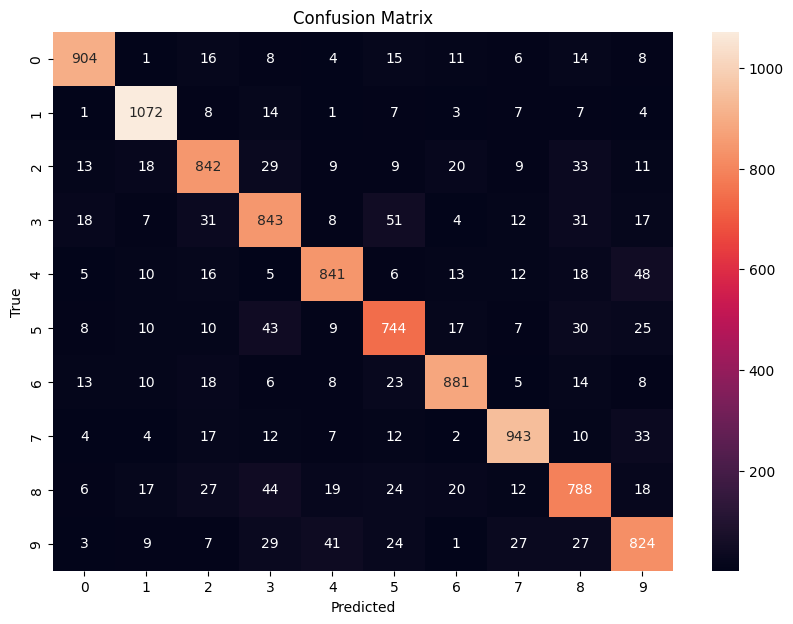

In [9]:
# Active Learning Loop
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = learner.query(x_test)
    learner.teach(X=x_test[query_idx].reshape(1, -1), y=y_test[query_idx])

    # Evaluate and print performance
    print('Performance after query {n}:'.format(n=idx + 1))
    y_pred = learner.predict(x_test)
    print_metrics(y_test, y_pred)